In [157]:
import tifffile
import numpy as np
import skimage.io as io
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib

import pandas as pd
import scanpy as sc
from matplotlib.pyplot import rc_context

import pickle
from tqdm import tqdm

In [158]:
markers = ['IL8', 'IL6', 'CCL11', 'SOX9', 'COL1A1', 'ACTB', 'EEF2', 'SPP1', 'RUNX1', 'PDL1', 'GAPDH', 'NANOG']

# Single cell analysis

In [185]:
fn = r'..\results\HCH\detected_dots\hch_006_3.pkl'
cell = pd.read_pickle(fn)

In [186]:
l = []
for k in cell.keys():
    l = l + cell[k]

In [187]:
t = np.array(l)
t.shape

(4279, 2)

In [188]:
adata = sc.AnnData(np.array(l))
adata.var_name = ['x','y']
adata.obsm['spatial'] = np.vstack((t[:,1],t[:,0])).T

In [189]:
sc.pp.neighbors(adata)

In [190]:
sc.tl.leiden(adata, resolution=1)

In [191]:
adata

AnnData object with n_obs × n_vars = 4279 × 2
    obs: 'leiden'
    uns: 'neighbors', 'leiden'
    obsm: 'spatial'
    obsp: 'distances', 'connectivities'

In [192]:
neighborhood = adata.obs['leiden'].tolist()

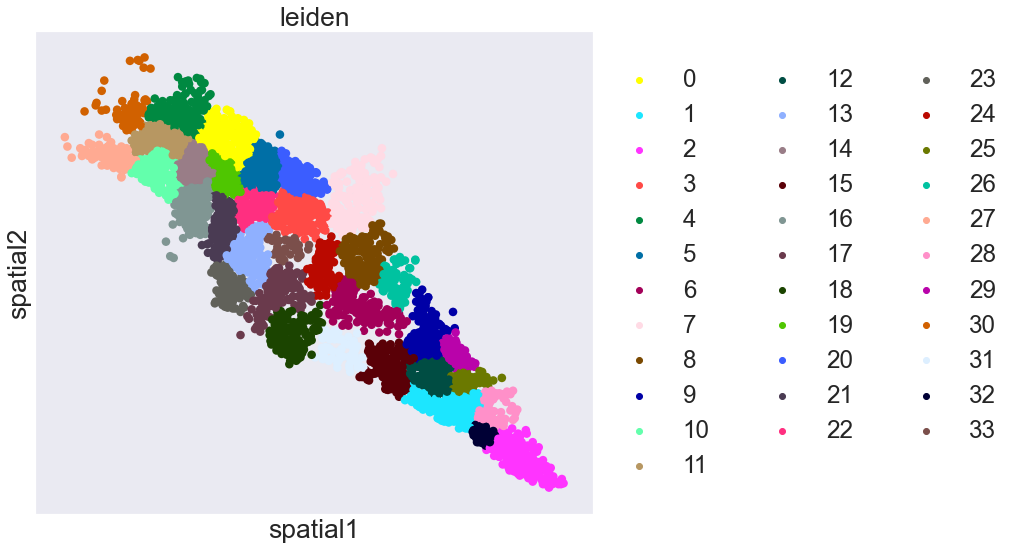

In [193]:
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.spatial(adata, color='leiden', spot_size=10)

In [174]:
neighborhood = adata.obs['leiden'].tolist()

In [175]:
len(np.unique(neighborhood))

172

In [145]:
pd.DataFrame(cell[k])

,0,1
0,989,1625
1,1155,1524
2,1201,1525
3,1249,1497
4,1275,1462
5,1326,1355
6,1329,1358
7,1489,1343
8,1672,1269


In [146]:
new_dic = {}
for k in cell.keys():
    df = pd.DataFrame(cell[k])
    df.columns = ['row', 'column']
    df['cluster'] = neighborhood[:df.shape[0]]
    neighborhood = neighborhood[df.shape[0]:]
    new_dic[k] = df

In [147]:
rna_neighbor_exp = np.zeros((172, 12))
i = 0
for k in new_dic.keys():
    for j in range(172):
         rna_neighbor_exp[j,i] = sum(item==str(j) for item in new_dic[k]['cluster'].tolist())
    i = i + 1

C:\Users\zfang38\Anaconda3\envs\scenv\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  """


In [148]:
pd.DataFrame(rna_neighbor_exp, columns=markers)

,IL8,IL6,CCL11,SOX9,COL1A1,ACTB,EEF2,SPP1,RUNX1,PDL1,GAPDH,NANOG
0,0.0,0.0,0.0,0.0,32.0,27.0,8.0,0.0,1.0,2.0,5.0,0.0
1,0.0,1.0,0.0,0.0,23.0,30.0,5.0,0.0,1.0,0.0,14.0,0.0
2,0.0,0.0,0.0,0.0,31.0,25.0,4.0,0.0,0.0,5.0,8.0,0.0
3,0.0,0.0,0.0,0.0,9.0,48.0,11.0,0.0,2.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,37.0,15.0,6.0,1.0,1.0,0.0,9.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
167,0.0,0.0,0.0,0.0,0.0,20.0,1.0,0.0,1.0,0.0,0.0,0.0
168,0.0,0.0,0.0,0.0,12.0,4.0,0.0,0.0,2.0,0.0,2.0,0.0
169,0.0,1.0,0.0,0.0,9.0,6.0,1.0,0.0,1.0,0.0,2.0,0.0
170,0.0,0.0,0.0,0.0,4.0,4.0,2.0,0.0,0.0,0.0,6.0,0.0


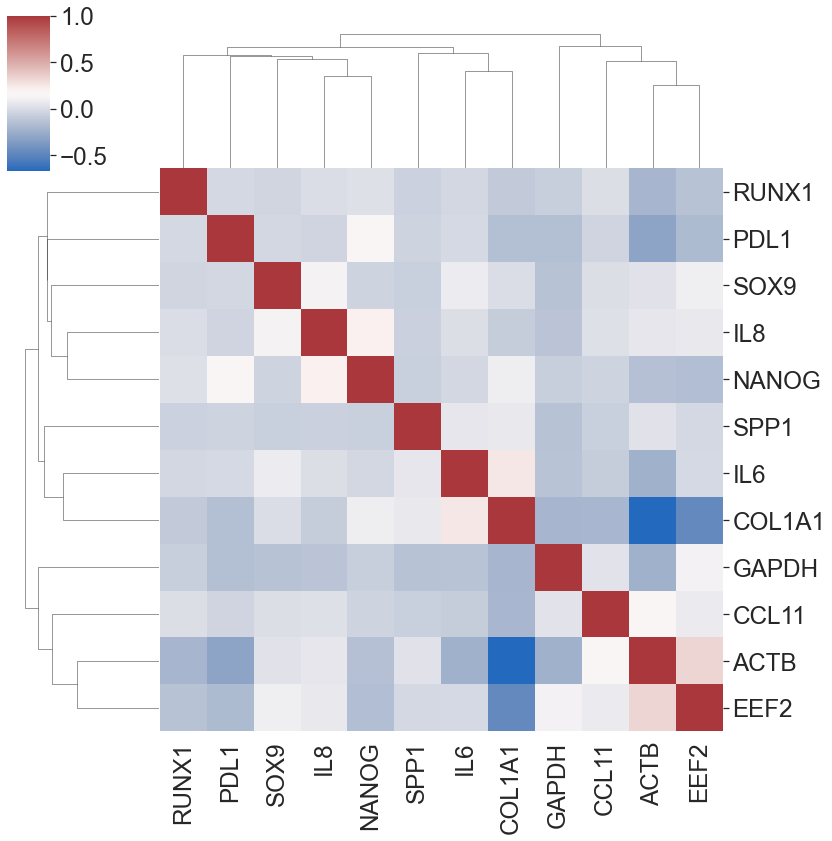

In [156]:
sns.set(font_scale=2.2)
sns.clustermap(correlation, figsize=(12,12), xticklabels=True, yticklabels=True, cmap='vlag')
# sns.clustermap(uc_corr, figsize=(12,12), xticklabels=True, yticklabels=True)
plt.savefig('.figures\uc_002_2 172 neighborhood subcellular correlation.png')

# Batch analysis

In [209]:
# in_dir is the directory containing all .pkl files that each contains all RNA positions in each cell.
in_dir = r'..\results\HBM\detected_dots2'
out_dir = r'..\results\HBM\patches'

In [210]:
fn_l = os.listdir(in_dir)
fn_l.sort()

In [211]:
cell = pd.read_pickle(os.path.join(in_dir, fn_l[0]))
list(cell.keys())

['GAPDH',
 'ACTB',
 'IL8',
 'IL6',
 'CCL11',
 'COL1A1',
 'NANOG',
 'SOX9',
 'EEF2',
 'SPP1',
 'RUNX1',
 'PDL1']

In [212]:
for fn in tqdm(fn_l):
    cell = pd.read_pickle(os.path.join(in_dir, fn))
    markers = list(cell.keys())
    l = []
    for k in cell.keys():
        l = l + cell[k]
    adata = sc.AnnData(np.array(l))
    adata.var_name = ['x','y']
    t = np.array(l)
    adata.obsm['spatial'] = np.vstack((t[:,1],t[:,0])).T
    sc.pp.neighbors(adata)
    sc.tl.leiden(adata, resolution=1)
    save_name = os.path.join(out_dir, fn.split('.')[0]+' clustered data.h5ad')
    adata.write(filename=save_name)
    neighborhood = adata.obs['leiden'].tolist()
    new_dic = {}
    for k in cell.keys():
        if len(cell[k]) == 0:
            new_dic[k] = pd.DataFrame(columns = ['row', 'column', 'cluster'])
            continue
        df = pd.DataFrame(cell[k])
        df.columns = ['row', 'column']
        df['cluster'] = neighborhood[:df.shape[0]]
        neighborhood = neighborhood[df.shape[0]:]
        new_dic[k] = df
    neighborhood = adata.obs['leiden'].tolist()
    rna_neighbor_exp = np.zeros((len(np.unique(neighborhood)) , 12))
    i = 0
    for k in new_dic.keys():
        for j in range(len(np.unique(neighborhood))):
             rna_neighbor_exp[j,i] = sum(item==str(j) for item in new_dic[k]['cluster'].tolist())
        i = i + 1
    expression_df = pd.DataFrame(rna_neighbor_exp, columns=markers)
    corr_df = expression_df.corr(method='pearson')
    corr_df = corr_df.fillna(0)
    save_name = os.path.join(out_dir, fn.split('.')[0]+' subcellular neighborhood.pkl')
    pickle.dump({'expression': expression_df, 'correlation': corr_df}, open(save_name, 'wb'))

100%|████████████████████████████████████████████████████████████████████████████████| 237/237 [04:01<00:00,  1.02s/it]
